In [38]:
from weightedCS import generate_MFS, get_sampling_weights, get_conf_seq, sample_indices 
from weightedCS import control_variate_values, control_variate_weights, get_bets
from utils import plot_results1
import numpy as np 
import matplotlib.pyplot as plt 

In [39]:
# First generate the data 
N1, N2  = 540, 960
N = N1+N2
N_vals = [N1, N2]
M_ranges = [ [1e2, 1e3], [1e5, 2*1e5]] 
f_ranges = [[0.4, 0.5], [1e-1, 2*1e-1]] 


plot_histogram=True 
plot_ratio = False

In [40]:
from weightedCS import get_wealth_process, sample_indices
from tqdm import tqdm 

def first_threshold_crossing(arr, th, max_time=100):
    if np.any(arr>th):
        return np.argmax(arr>th)+1
    else:
        return max_time

a=0.5

def get_StoppingTime_ratio(num_trials, l, delta_m=0.01, progress_bar=False, 
                            random_seed=None, return_stopping_times=False):
    if random_seed is not None:
        np.random.seed(random_seed)
    print(f'{num_trials} trials,  l={l:.2f}, N={N}')
    StoppingTimes, StoppingTimesCV = np.zeros((num_trials)), np.zeros((num_trials))

    range_ = range(num_trials)
    range_ = tqdm(range_) if progress_bar else range_
    # for trial in tqdm(range(num_trials)):
    for trial in range_:
        M, f, S = generate_MFS(N_vals=N_vals, N=N, M_ranges=M_ranges, f_ranges=f_ranges, a=a)
        Pi = M/M.sum() 
        m_star = np.sum(Pi*f) 

        # m = m_star + 0.01
        m = m_star + delta_m
        method = lambda M, S: M #propM strategy
        use_propMS = False
        # l= 0.9
        S = f*l + (1-l)*np.random.random((N,))
        SW = get_sampling_weights(M=M, S=S, method=method)
        max_f_S_ratio = max(np.abs(f/S))
        
        Idx = sample_indices(N, SamplingWeights=SW) 


        W, _, _, _ = get_wealth_process(m, f, Pi, Idx, SamplingWeights=SW, S=S,  
                                use_propMS=use_propMS, max_lambda_val=2.0, max_f_S_ratio=max_f_S_ratio,
                                use_CV=False, beta_max=0.5)
        StoppingTimes[trial] = first_threshold_crossing(W, th=20, max_time=N)
        
        Wcv, _, _, _ = get_wealth_process(m, f, Pi, Idx, SamplingWeights=SW, S=S,  
                                use_propMS=use_propMS, max_lambda_val=2.0, max_f_S_ratio=max_f_S_ratio,
                                use_CV=True, beta_max=0.5)
        
        StoppingTimesCV[trial] = first_threshold_crossing(Wcv, th=20, max_time=N)


    ratio = StoppingTimes.mean() / StoppingTimesCV.mean()
    if return_stopping_times:
        return ratio, StoppingTimes, StoppingTimesCV
    else:
        return ratio

In [41]:
# import matplotlib.pyplot as plt 
# plt.hist(StoppingTimes, label='no-CV', alpha=0.3, density=True)
# plt.hist(StoppingTimesCV, label='CV', alpha=0.3, density=True)
# plt.legend()
# plt.show()

# print(f'No CV: {StoppingTimes.mean()}, \t CV: {StoppingTimesCV.mean()}')

In [42]:
ll = np.linspace(0.1, 0.95, 15) 
Ratio = np.zeros(ll.shape)
delta_m = 0.0
random_seed = np.random.randint(low=0, high=100000)
# random_seed = 44805
num_trials = 200

if plot_ratio:
    for i, l in enumerate(ll):
        # print(f'({i+1}/{len(ll)})') 
        Ratio[i] = get_StoppingTime_ratio(num_trials=num_trials,
                                            l=l, delta_m=delta_m, 
                                            random_seed=random_seed, 
                                            return_stopping_times=False)

In [43]:
if plot_ratio:
    # delta_m = 0.05
    # random_seed = 10
    plt.plot(ll, Ratio)
    plt.plot(ll, np.ones(ll.shape), '--')
    title = 'Ratio of Average Stopping Times without and with \n Control Variates '+f'at $m=m^*$+ {delta_m}'
    plt.title(title, fontsize=15)
    plt.ylabel('Ratio (without CV / with CV)', fontsize=13)
    plt.xlabel('Correlation between $S$ and $f$', fontsize=13)
    # plt.savefig(f'../data/Stopping_Time_ratio_(random_seed={random_seed})_.png', dpi=450)

## Histogram of Stopping Times with and without Control Variates

20 trials,  l=0.90, N=1500
Ratio = 1.0708535816300033




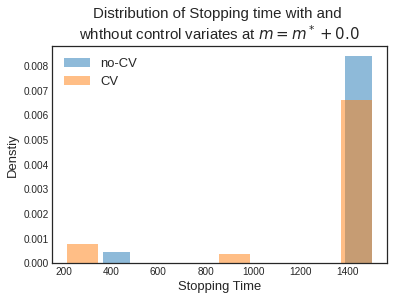

In [44]:
delta_m = 0.00
num_trials=20
l=0.9
if plot_histogram:
    _, Stop, StopCV = get_StoppingTime_ratio(num_trials=num_trials,
                                            l=l, delta_m=delta_m, 
                                            random_seed=random_seed, 
                                            return_stopping_times=True)

    print(f'Ratio = {Stop.mean()/StopCV.mean()}')
    print('\n')
    plt.figure()
    plt.hist(x=Stop, density=True, label='no-CV', alpha=0.5)
    plt.hist(x=StopCV, density=True, label='CV', alpha=0.5)
    plt.xlabel('Stopping Time', fontsize=13)
    plt.ylabel('Denstiy', fontsize=13)
    plt.legend(fontsize=13)
    title = 'Distribution of Stopping time with and \n' 
    title += rf'whthout control variates at $m=m^*+{delta_m}$'
    plt.title(title, fontsize=15)

In [45]:
StopCV[StopCV<1500]

array([299., 943., 215.])